# Section 2: Seam Carving

For this part of the assignment, you will need to read and implement the seam carving algorithm described the SIGGRAPH 2007 paper [Seam Carving for Content-Aware Image Resizing](http://www.faculty.idc.ac.il/arik/SCWeb/imret/imret.pdf) by Shai Avidan and Ariel Shamir.     <br />   <br />


![Seam Carving Teaser Image](http://www.faculty.idc.ac.il/arik/SCWeb/imret/teaser.jpg)




<br />For now we will focus specifically on seam removal. Visit the [webpage](http://www.faculty.idc.ac.il/arik/SCWeb/imret/index.html) for more applications of Seam Carving.  <br />   <br />  



#### Implementation Steps:


1. Read an image and convert it to grayscale if required. This function is already implemented for you.



2. Compute an energy image as described in Equation 1 of the paper. For this you should implement your own differentiation filter. 



3. Calculate the cumulative minimum energy map along the horizontal and vertical directions using the energy image computed in step 2. 



4. Find optimal vertical and horizontal seams based on the result of step 3, and remove the pixels from the image to get resized images. 


The steps for seam insertion are very similar to these. 

Remember to typecast `uint8` to `float` where ever needed. Have fun and experiment with this notebook!

### Exporting this notebook to a .py script

Once you are done implementing all the required functions in this notebook, you can go ahead and use the provided `notebook2script.py` script to convert this notebook into a `.py` file for submission.    <br />    <br />



The provided script will look for all the cells with the `#export` tag in the first line of the cell and only add those cells to the final script. This tag is already present for all the required cells in this notebook.   <br />   <br />



If you add any cells that you want to include in the submission, you can add the tag to the top of the cell.    <br />   <br />



The idea behind this is that students get to experiment, print and plot freely in the notebook while ensuring the submission file remains Gradescope friendly. Please avoid putting the `#export` tag on cells with `print`, `imshow`, and `plot` statements. 

In [3]:
#export
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, signal
from imageio import imread, imsave

The commands in the follwing cell will plot all images/plots in an interactove window. If you would prefer to not have interactive plots, comment out `%matplotlib notebook` and uncomment `%matplotlib inline` instead. 

You can use `plt.rcParams['figure.figsize']` to make all the plots in this notebook bigger or smaller. 

In [4]:
%matplotlib notebook
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (20, 20)
# plt.rcParams['image.cmap'] = 'gray'

In [5]:
#export
def  rgb2gray(img):
    """
    Converts an RGB image into a greyscale image
    
    Input: ndarray of an RGB image of shape (H x W x 3)
    Output: ndarray of the corresponding grayscale image of shape (H x W)
    
    """
    
    if(img.ndim != 3 or img.shape[-1] != 3):
        print("Invalid image! Please provide an RGB image of the shape (H x W x 3) instead.".format(img.ndim))
        return None
    
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

<IPython.core.display.Javascript object>


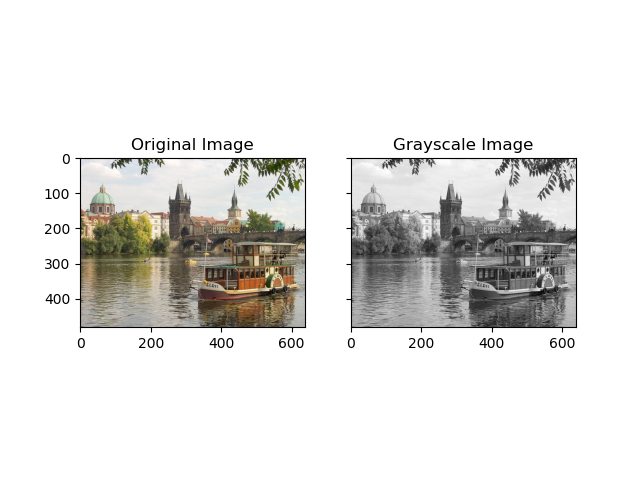

Text(0.5, 1.0, 'Grayscale Image')

In [6]:
imgPrague = imread("./inputSeamCarvingPrague.jpg")
imgPragueGrayscale = rgb2gray(imgPrague)

fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].imshow(imgPrague)
axes[0].set_title("Original Image")

axes[1].imshow(imgPragueGrayscale, cmap='gray')
axes[1].set_title("Grayscale Image")

### Energy Image

From the paper we know that the energy function $e(\mathcal{I})$ is calculated as:

$$
\begin{align}
e(\mathcal{I}) &= \left|\frac{\partial}{\partial x} \mathcal{I} \right| + \left| \frac{\partial}{\partial y} \mathcal{I} \right|
\end{align}
$$

We can calculate the approximate derivatives the input image $\mathcal{I}$ using a differentiation filter in the x and y directions. 


In the following cell, fill in your filter choices and use `scipy.ndimage.correlate()` to compute the vertical and horizontal gradients `gx` and `gy`. Modify the parameters of `scipy.ndimage.correlate()` to extend the input image by filling 0s beyond the edge.

In [9]:
#export
def compute_gradients(img):
    """
    Computes the gradients of the input image in the x and y direction using a 
    differentiation filter.
    
    ##########################################################################
    # TODO: Design a differentiation filter and update the docstring. Stick  #
    # to a pure differentiation filter for this assignment.                  #
    # Hint: Look at Slide 14 from Lecture 3: Gradients.                      #
    ##########################################################################
    
    Input: Grayscale image of shape (H x W)
    Outputs: gx, gy gradients in x and y directions respectively
    
    """    
#     img = cv2.GaussianBlur(img,(3,3),0).astype(np.int8)
#     #turn in into gray to generate x and y gradients
#     gray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
#     #gradient x
#     sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
#     #gradient 7
#     sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
#     rgb = np.copy(img)
#     rgb = np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
#     print("rgb shape is" ,rgb.shape)
    gx = -ndimage.prewitt(img, axis=1, mode='constant')
    gy = -ndimage.prewitt(img, axis=0, mode='constant')
#   #gx = gy = np.zeros_like(img)
    
    ##########################################################################
    # TODO: Design a pure differentiation filter and use correlation to      #
    # compute the gradients gx and gy. You might have to try multiple        #
    # filters till the test below passes. All the tests after will fail if   #
    # this one does not pass.                                                #
    ##########################################################################
    return gx, gy

In [10]:
def test_compute_gradients():
    
    np.random.seed(100)
    test_input = np.random.randint(0, 255, size=(5,5))
    
    expected_gx = np.array(
        [[-200., -118.,    3.,  -62.,  197.],
         [-253.,  -86., -170.,  -10.,  423.],
         [-470., -233.,  126.,  107.,  344.],
         [-401.,   -6.,   93.,   65.,  308.],
         [-348.,  -38.,  266.,   13.,   82.]]
    )

    expected_gy = np.array(
        [[-255., -393., -408., -412., -274.],
         [-119., -118., -151.,  -49.,  -50.],
         [ -20., -122.,  -97.,    5.,  107.],
         [-184., -178.,  120.,   44.,   38.],
         [ 275.,  515.,  505.,  407.,  167.]]
    )
    
    print("Input image: \n", test_input)
    
    gx, gy = compute_gradients(test_input)
    
    if(np.allclose(expected_gx, gx)):
        print("\n\nVertical gradients computed correctly!")
    else:
        print("\n\nVertical gradient is incorrect")
        print("\n\nComputed gx:\n", gx)
        
    if(np.allclose(expected_gy, gy)):
        print("\n\nHorizontal gradients computed correctly!")
    else:
        print("\n\nHorizontal gradient is incorrect")
        print("\n\nComputed gy:\n", gy)
    
    
    
test_compute_gradients()

Input image: 
 [[  8  24  67 103  87]
 [ 79 176 138  94 180]
 [ 98  53  66 226  14]
 [ 34 241 240  24 143]
 [228 107  60  58 144]]


Vertical gradients computed correctly!


Horizontal gradients computed correctly!


Now we compute the gradients of the Prague image.

In [7]:
gxPrague, gyPrague = compute_gradients(imgPragueGrayscale)

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].imshow(gxPrague, cmap='gray')
axes[0].set_title("Vertical gradients")

axes[1].imshow(gyPrague, cmap='gray')
axes[1].set_title("Horizontal gradients")

rgb shape is (480, 640)


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Horizontal gradients')

Now that we have computed gradients, we can use them to compute the energy image as described above. 

In [8]:
#export
def energy_image(img):
    """
    Computes the energy of the input image according to the energy function:
    
        e(I) = abs(dI/dx) + abs(dI/dy)
        
    Use compute_gradients() to help you calculate the energy image. Remember to normalize
    energyImage by dividing it by max(energyImage).

    Input: image of the form (H x W) or (H x w x 3)
    Output: array of energy values of the image computed according to the energy function. 

    """
    gx, gy = compute_gradients(img)
    image = abs(gx) + abs(gy)
    image = image / np.max(image)

    
    ##########################################################################
    # TODO: Compute the energy of input using the defined energy function.   #                                             #
    ##########################################################################
    
    return image

In [9]:
def test_energy_image():
    np.random.seed(100)
    testInput = np.random.randint(0, 255, size=(5,5))
    
    expectedEnergyImage = np.array(
        [[0.59014267, 0.66277562, 0.53307393, 0.61478599, 0.61089494],
         [0.48249027, 0.26459144, 0.41634241, 0.07652399, 0.61348898],
         [0.63553826, 0.46044099, 0.28923476, 0.14526589, 0.5849546 ],
         [0.75875486, 0.2386511 , 0.27626459, 0.14137484, 0.44876783],
         [0.8080415 , 0.71725032, 1.        , 0.54474708, 0.3229572 ]]
    )
    
    energyImage =  energy_image(testInput)
    
    if(np.allclose(expectedEnergyImage, energyImage)):
        print("Energy Image computed correctly!")
        
    else:
        print("Incorrect energy image.\n\n", "Computed energy image:\n", energyImage)

test_energy_image()

rgb shape is (5, 5)
Energy Image computed correctly!


In [10]:
energyImagePrague = energy_image(imgPrague)

fig, axes = plt.subplots(1, 1, sharey=True)
axes.imshow(energyImagePrague)
axes.set_title("Energy Image")

rgb shape is (480, 640, 3)


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Energy Image')

### Cumulative Minimum Energy Map


We will use dynamic programming to find the minimal connected seam. For this, we need to compute a cumulative minimum energy map for all the possible connected seams as:

$$
\begin{align}
M(i, j) &= e(i, j) + \min(M(i-1, j-1), M(i-1, j), M(i-1, j+1))
\end{align}
$$

The minimum value in the last row of the map is the last pixel of the seam we want remove.

In [11]:
#export
def cumulative_minimum_energy_map(energyImage, seamDirection):
    """
    Calculates the cumulative minim energy map according to the function:
        
        M(i, j) = e(i, j) + min(M(i-1, j-1), M(i-1, j), M(i-1, j+1))
    
    Inputs: 
        energyImage: Results of passign the input image to energy_image()
        seamDirection: 'HORIZONTAL' or 'VERTICAL'
        
    Output: cumulativeEnergyMap
    
    """
    if(len(energyImage.shape)<3):
    
        M = energyImage.copy()
        r, c= energyImage.shape
        backtrack = np.zeros_like(M, dtype=np.int)
        cumulativeEnergyMap = np.zeros_like(energyImage)
        if (seamDirection == "VERTICAL"):
            for i in range(1, r):
                for j in range(0, c):
                    # Handle the left edge of the image, to ensure we don't index -1
                    if j == 0:
                        idx = np.argmin(M[i - 1, j:j + 2])
                        backtrack[i, j] = idx + j
                        min_energy = M[i - 1, idx + j]
                    else:
                        idx = np.argmin(M[i - 1, j - 1:j + 2])
                        backtrack[i, j] = idx + j - 1
                        min_energy = M[i - 1, idx + j - 1]

                    M[i, j] += min_energy
        else:
            for j in range(1,c):
                for i in range(0,r):
                    # Handle the left edge of the image, to ensure we don't index -1
                    if i == 0:
                        idy = np.argmin(M[i: i+2, j-1])
                        backtrack[i, j] = idy + i
                        min_energy = M[idy + i, j-1]
                    else:
                        idy = np.argmin(M[i - 1: i+2, j - 1])
                        backtrack[i, j] = idy + i - 1
                        min_energy = M[idy + i - 1, j-1]

                    M[i, j] += min_energy
    else: 
        assert len(energyImage.shape) == 3 and energyImage.shape[-1] == 3
        [B, G, R] = np.squeeze(np.split(energyImage, energyImage.shape[-1], -1), axis=-1)
        B = cumulative_minimum_energy_map(B, seamDirection)
        np.clip(B, 0,1, out = B)
        G = cumulative_minimum_energy_map(G, seamDirection)
        np.clip(G, 0,1, out = G)
        R = cumulative_minimum_energy_map(R, seamDirection)
        np.clip(R, 0,1, out = R)
        M=np.dstack((R,G,B))
        print(np.max(M))
        print(np.min(M))
#     if(len(energyImage.shape)<3):
#         if seamDirection == "HORIZONTAL":
#             energyImage = energyImage.T
#         rows, columns = energyImage.shape
#         cumulative_minimum_energy = np.zeros((rows, columns), dtype='float64')
#         cumulative_minimum_energy[0] = energyImage[0]
#         for i in range(1, rows):
#             for j in range(columns):
#                 val1 = cumulative_minimum_energy[i-1][j - 1] if j > 0 else cumulative_minimum_energy[i-1][j]
#                 val2 = cumulative_minimum_energy[i-1][j]
#                 val3 = cumulative_minimum_energy[i-1][j + 1] if j < columns - 1 else cumulative_minimum_energy[i-1][j]
#                 cumulative_minimum_energy[i][j] = energyImage[i][j] + min(val1, val2, val3)
#         if seamDirection == "HORIZONTAL":
#             cumulative_minimum_energy = cumulative_minimum_energy.T
#         return cumulative_minimum_energy
#     else: 
#         [B, G, R] = np.squeeze(np.split(energyImage, energyImage.shape[-1], -1), axis=-1)
#         B = cumulative_minimum_energy_map(B, seamDirection)
#         np.clip(B, 0,1, out = B)
#         G = cumulative_minimum_energy_map(G, seamDirection)
#         np.clip(G, 0,1, out = G)
#         R = cumulative_minimum_energy_map(R, seamDirection)
#         np.clip(R, 0,1, out = R)
#         M=np.dstack((R,G,B))
#         return M
    
    
    ##########################################################################
    # TODO: Compute the cumulative minimum energy map in the input           #
    # seamDirection for the input energyImage. It is fine it is not fully    #
    # vectorized.                                                            #
    ##########################################################################
        
    return M

In [12]:
def test_cumulative_minimum_energy_map():
    energyImg = np.array(
        [[0.33333333, 1.        , 0.42995169, 0.17874396, 0.33333333],
         [0.70531401, 0.09661836, 0.1352657 , 0.48309179, 0.73913043],
         [0.41062802, 0.58454106, 0.57487923, 0.47826087, 0.83091787],
         [0.97101449, 0.28019324, 0.14009662, 0.85990338, 0.08695652],
         [0.04830918, 0.45410628, 0.46859903, 0.97584541, 0.28019324]]
    )
    
    #CEM == cumulativeEnergyMap
    expected_CEM_vertical = np.array(
        [[0.33333333, 1.        , 0.42995169, 0.17874396, 0.33333333],
        [1.03864734, 0.42995169, 0.31400966, 0.66183575, 0.91787439],
        [0.84057971, 0.89855072, 0.88888889, 0.79227053, 1.49275362],
        [1.8115942 , 1.12077295, 0.93236715, 1.65217391, 0.87922705],
        [1.16908213, 1.38647343, 1.40096618, 1.85507246, 1.15942029]]
    )
    
    expected_CEM_horizontal = np.array(
        [[0.33333333, 1.33333333, 0.85990338, 0.74396135, 1.07729468],
        [0.70531401, 0.42995169, 0.56521739, 1.04830918, 1.48309178],
        [0.41062802, 0.99516908, 0.90338165, 0.94685991, 1.77777778],
        [0.97101449, 0.32850242, 0.46859904, 1.32850242, 1.03381643],
        [0.04830918, 0.50241546, 0.79710145, 1.44444445, 1.60869566]]
    )
    
    CEM_vertical = cumulative_minimum_energy_map(energyImg, 'VERTICAL')
    CEM_horizontal = cumulative_minimum_energy_map(energyImg, 'HORIZONTAL')
    
    if(np.allclose(expected_CEM_vertical, CEM_vertical)):
        print("Vertical CEM computed correctly!")
    else:
        print("Vertical CEM is incorrect")
        print("\n\nComputed Vertical CEM:\n", CEM_vertical)
        
    if(np.allclose(expected_CEM_horizontal, CEM_horizontal)):
        print("Horizontal CEM computed correctly!")
    else:
        print("Horizontal CEM is incorrect")
        print("\n\nComputed CEM:\n", CEM_horizontal)

test_cumulative_minimum_energy_map()

Vertical CEM computed correctly!
Horizontal CEM computed correctly!


Now let's try it for the Prague image!

In [13]:
# print(np.max(energyImagePrague))
# print(np.min(energyImagePrague))
CEMVerticalPrague = cumulative_minimum_energy_map(energyImagePrague, 'VERTICAL')
CEMHorizontalPrague = cumulative_minimum_energy_map(energyImagePrague, 'HORIZONTAL')

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].imshow(CEMVerticalPrague)
axes[0].set_title("Vertical Cumulative Minimum Energy Map")

axes[1].imshow(CEMHorizontalPrague)
axes[1].set_title("Horizontal Cumulative Minimum Energy Map")

1.0
0.0
1.0
0.0


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Horizontal Cumulative Minimum Energy Map')

As a check for optimality, the next cell should run in $\approx$ 2 seconds. You are welcome to optimize it further if you are interested, but it is not necessary and no points will be awarded for doing so. 

In [14]:
%%timeit
cumulative_minimum_energy_map(energyImagePrague, seamDirection='VERTICAL')
cumulative_minimum_energy_map(energyImagePrague, seamDirection='HORIZONTAL')

1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
6.01 s ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Finding Seams

Now that we have both the cumulative minimum energy map, we can find the minimal connected vertical and horizontal seams by tracing its path through the CEM. 

Hint: The end of the seam is at the minimum of the last row (or column) of the CEM. 

In [15]:
#export
def find_optimal_vertical_seam(cumulativeEnergyMap): 
    """
    Finds the least connected vertical seam using a vertical cumulative minimum energy map.
    
    Input: Vertical cumulative minimum energy map.
    Output: 
        verticalSeam: vector containing column indices of the pixels in making up the seam.
        
    """
    
    if(len(cumulativeEnergyMap.shape)<3):
        rows, columns = cumulativeEnergyMap.shape
        result = []
        minColumn = 0
        min = cumulativeEnergyMap[rows-1][minColumn]
        for j in range(1, columns):
            if cumulativeEnergyMap[rows-1][j] < min:
                minColumn = j
                min = cumulativeEnergyMap[rows-1][minColumn]
        result.append(minColumn)
        for i in range(rows - 2, -1, -1):
            min = cumulativeEnergyMap[i][minColumn]
            for j in range(minColumn - 1, minColumn + 2):
                if j >= 0 and j < columns:
                    if cumulativeEnergyMap[i][j] < min:
                        minColumn = j
                        min = cumulativeEnergyMap[i][minColumn]
            result.append(minColumn)
        return result[::-1]
    else: 
        assert len(cumulativeEnergyMap.shape) == 3 and cumulativeEnergyMap.shape[-1] == 3
        [B, G, R] = np.squeeze(np.split(cumulativeEnergyMap, cumulativeEnergyMap.shape[-1], -1), axis=-1)
        B = find_optimal_vertical_seam(B)
#         np.clip(B, 0,1, out = B)
        G = find_optimal_vertical_seam(G)
#         np.clip(G, 0,1, out = G)
        R = find_optimal_vertical_seam(R)
#         np.clip(R, 0,1, out = R)
        M=np.dstack((R,G,B))
        return M
#     verticalSeam = [0]*cumulativeEnergyMap.shape[0]
    
    ##########################################################################
    # TODO: Find the minimal connected vertical seam using the input         #
    # cumulative minimum energy map.                                         #
    ##########################################################################
    
#     return verticalSeam

In [16]:
#export
def find_optimal_horizontal_seam(cumulativeEnergyMap):
    """
    Finds the least connected horizontal seam using a horizontal cumulative minimum energy map.
    
    Input: Horizontal cumulative minimum energy map.
    Output: 
        horizontalSeam: vector containing row indices of the pixels in making up the seam.
        
    """
    if(len(cumulativeEnergyMap.shape)<3):
        rows, columns = cumulativeEnergyMap.shape
        cumulativeEnergyMap = cumulativeEnergyMap.T
        rows, columns = cumulativeEnergyMap.shape
        result = []
        minColumn = 0
        min = cumulativeEnergyMap[rows-1][minColumn]
        for j in range(1, columns):
            if cumulativeEnergyMap[rows-1][j] < min:
                minColumn = j
                min = cumulativeEnergyMap[rows-1][minColumn]
        result.append(minColumn)
        for i in range(rows - 2, -1, -1):
            min = cumulativeEnergyMap[i][minColumn]
            for j in range(minColumn - 1, minColumn + 2):
                if j >= 0 and j < columns:
                    if cumulativeEnergyMap[i][j] < min:
                        minColumn = j
                        min = cumulativeEnergyMap[i][minColumn]
            result.append(minColumn)
        return result[::-1]
    else:
#         rows,columns, layers = cumulativeEnergyMap.shape
        assert len(cumulativeEnergyMap.shape) == 3 and cumulativeEnergyMap.shape[-1] == 3
        [B, G, R] = np.squeeze(np.split(cumulativeEnergyMap, cumulativeEnergyMap.shape[-1], -1), axis=-1)
        B = find_optimal_horizontal_seam(B)
#         np.clip(B, 0,1, out = B)
        G = find_optimal_horizontal_seam(G)
#         np.clip(G, 0,1, out = G)
        R = find_optimal_horizontal_seam(R)
#         np.clip(R, 0,1, out = R)
        horizontalSeam=np.dstack((R,G,B))
        
#     horizontalSeam = [0]*cumulativeEnergyMap.shape[1]
    
    ##########################################################################
    # TODO: Find the minimal connected horizontal seam using the input       #
    # cumulative minimum energy map.                                         #
    ##########################################################################
    
    return horizontalSeam

Let's test them out!

In [17]:
def test_find_optimal_seam():
    testCEMVertical = np.array(
        [[0.33333333, 1.        , 0.42995169, 0.17874396, 0.33333333],
        [1.03864734, 0.42995169, 0.31400966, 0.66183575, 0.91787439],
        [0.84057971, 0.89855072, 0.88888889, 0.79227053, 1.49275362],
        [1.8115942 , 1.12077295, 0.93236715, 1.65217391, 0.87922705],
        [1.16908213, 1.38647343, 1.40096618, 1.85507246, 1.15942029]]
    )
    
    testCEMHorizontal = np.array(
        [[0.33333333, 1.33333333, 0.85990338, 0.74396135, 1.07729468],
        [0.70531401, 0.42995169, 0.56521739, 1.04830918, 1.48309178],
        [0.41062802, 0.99516908, 0.90338165, 0.94685991, 1.77777778],
        [0.97101449, 0.32850242, 0.46859904, 1.32850242, 1.03381643],
        [0.04830918, 0.50241546, 0.79710145, 1.44444445, 1.60869566]]
    )
    
    expectedVerticalSeam = np.array([3, 2, 3, 4, 4])
    expectedHorizontalSeam = np.array([4, 3, 3, 2, 3])
    
    verticalSeam = find_optimal_vertical_seam(testCEMVertical)
    horizontalSeam = find_optimal_horizontal_seam(testCEMHorizontal)
    
    if(np.array_equal(expectedVerticalSeam, verticalSeam)):
        print("Vertical seam computed correctly!")
    else:
        print("Vertical seam incorrect!\nComputed vertical seam:\n\n", verticalSeam)
        
    if(np.array_equal(expectedHorizontalSeam, horizontalSeam)):
        print("Horizontal seam computed correctly!")
    else:
        print("Horizontal seam incorrect!\nComputed Horizontal seam:\n\n", horizontalSeam)

test_find_optimal_seam()

Vertical seam computed correctly!
Horizontal seam computed correctly!


It's hard to understand what these functions are calculating. To help with that, let's write a function `display_seam()` to visualize the computed seam. Plot a line tracing the seam onto the input image.

In [18]:
def display_seam(img, seam, seamType): 
    """
    Utility to plot computed seams onto the input image. 
    
    Inputs:
        img: Image for which the seam was computed
        seam: column/row indices of the seam to be visualized
        seamType: indicates horizontal or vertical seam
    """
    print(img.shape)
    if(len(img.shape)<3):
        rows, columns = img.shape
    else: 
        rows, columns, channels = img.shape
    fig, ax = plt.subplots()
    imgplot = ax.imshow(img)
    if seamType == "VERTICAL":
        ax.plot(seam, range(rows))
    if seamType == "HORIZONTAL":
        ax.plot(range(columns), seam)
    plt.show()
    ##########################################################################
    # TODO: Using matplolib, display the image and draw the input seam onto  #
    # the image. Your code should be able to handle both vertical and        #
    # horizontal seams.                                                      #
    ##########################################################################

Now we calculate the first vertical and horizontal seam for the Prague image and visualize them

In [19]:
verticalSeam = find_optimal_vertical_seam(CEMVerticalPrague)
horizontalSeam = find_optimal_horizontal_seam(CEMHorizontalPrague)

display_seam(imgPrague, verticalSeam, seamType = 'VERTICAL')
display_seam(imgPrague, horizontalSeam, seamType = 'HORIZONTAL')

(480, 640, 3)


<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (1, 480, 3) and (480,)

### Seam Removal

Now that we know which seam to remove, let's use it to write a function that reduces the width or height of an image by 1 pixel by deleting the pixels that form the seam.

In [ ]:
# export
def reduce_width(img, energyImage):
    """
    Removes pixels along a seam, reducing the width of the input image by 1 pixel.
    
    Inputs:
        img: RGB image of shape (H x W x 3) from which a seam is to be removed.
        energyImage: The energy image of the input image.
        
    Outputs:
        reducedColorImage: The input image whose width has been reduced by 1 pixel
        reducedEnergyImage: The energy image whose width has been reduced by 1 pixel
    """
    reducedEnergyImageSize = (energyImage.shape[0], energyImage.shape[1] - 1)
    reducedColorImageSize = (img.shape[0], img.shape[1] - 1, 3)
    print(reducedEnergyImageSize, reducedColorImageSize)
    
#     reducedColorImage = np.zeros(reducedColorImageSize)
#     reducedEnergyImage = np.zeros(reducedEnergyImageSize)
    
    rows, columns, channels = img.shape
    cumulativeEnergyMap = cumulative_minimum_energy_map(energyImage, "VERTICAL")
    verticalSeam = find_optimal_vertical_seam(cumulativeEnergyMap)
    resultimg = np.zeros((rows, columns-1, channels))
    resulteng = np.zeros((rows, columns-1))
    for i in range(rows):
        column = verticalSeam[i]
        resultimg[i, :column, :] = img[i, :column, ]
        resultimg[i, column:] = img[i, column + 1:]
        resulteng[i, :column] = energyImage[i, :column]
        resulteng[i, column:] = energyImage[i, column + 1:]
    return resultimg, resulteng
    
    ##########################################################################
    # TODO: Compute the cumulative minimum energy map and find the minimal   #
    # connected vertical seam. Then, remove the pixels along this seam.      #
    ##########################################################################
    
    return reducedColorImage, reducedEnergyImage

In [ ]:
#export
def reduce_height(img, energyImage):
    """
    Removes pixels along a seam, reducing the height of the input image by 1 pixel.
    
    Inputs:
        img: RGB image of shape (H x W x 3) from which a seam is to be removed.
        energyImage: The energy image of the input image.
        
    Outputs:
        reducedColorImage: The input image whose height has been reduced by 1 pixel
        reducedEnergyImage: The energy image whose height has been reduced by 1 pixel
    """
    
    reducedEnergyImageSize = tuple((energyImage.shape[0] - 1, energyImage.shape[1]))
    reducedColorImageSize = tuple((img.shape[0] - 1, img.shape[1], 3))
    
#     reducedColorImage = np.zeros(reducedColorImageSize)
#     reducedEnergyImage = np.zeros(reducedEnergyImageSize)
    rows, columns, channels = img.shape
    cumulativeEnergyMap = cumulative_minimum_energy_map(energyImage, "HORIZONTAL")
    horizontalSeam = find_optimal_horizontal_seam(cumulativeEnergyMap)
    resultimg = np.zeros((rows-1, columns, channels))
    resulteng = np.zeros((rows-1, columns))
    for i in range(columns):
        row = horizontalSeam[i]
        resultimg[:row, i, :] = img[:row, i, ]
        resultimg[row:, i] = img[row+1:, i]
        resulteng[:row, i] = energyImage[:row, i]
        resulteng[row:, i] = energyImage[row+1:, i]
    return resultimg, resulteng
    ##########################################################################
    # TODO: Compute the cumulative minimum energy map and find the minimal   #
    # connected horizontal seam. Then, remove the pixels along this seam.    #
    ##########################################################################
    
#     return reducedColorImage, reducedEnergyImage

In [ ]:
def test_reduce_width():
    np.random.seed(100)
    testInput = np.array(np.random.uniform(0, 255, size=(5,5)), dtype=np.uint8)
    testInputRGB = np.transpose(np.array([testInput, testInput, testInput]), (1, 2, 0))

    testEnergyImage = np.array(
        [[0.33333333, 1.        , 0.42995169, 0.17874396, 0.33333333],
         [0.70531401, 0.09661836, 0.1352657 , 0.48309179, 0.73913043],
         [0.41062802, 0.58454106, 0.57487923, 0.47826087, 0.83091787],
         [0.97101449, 0.28019324, 0.14009662, 0.85990338, 0.08695652],
         [0.04830918, 0.45410628, 0.46859903, 0.97584541, 0.28019324]]
    )

    expectedReducedColorImage = np.array([[138,  70, 108,   1],
                                          [ 31, 171,  34, 146],
                                          [227,  53,  47,  56],
                                          [249, 206,  43, 208],
                                          [110, 239, 208,  85]])
    
    expectedReducedColorImage = np.transpose(
        np.array(
            [expectedReducedColorImage, expectedReducedColorImage, expectedReducedColorImage]
        ), (1, 2, 0)
    )
    expectedReducedEnergyImage = np.array(
        [[0.33333333, 1.        , 0.42995169, 0.33333333],
        [0.70531401, 0.09661836, 0.48309179, 0.73913043],
        [0.41062802, 0.58454106, 0.57487923, 0.83091787],
        [0.97101449, 0.28019324, 0.14009662, 0.85990338],
        [0.04830918, 0.45410628, 0.46859903, 0.97584541]]
    )
    
    reducedColorImage, reducedEnergyImage = reduce_width(testInputRGB, testEnergyImage)
    
    if(np.allclose(expectedReducedEnergyImage, reducedEnergyImage)):
        print("Width of energy image reduced correctly!")
    else:
        print("Width reduction of energy image incorrect.\nComputed energy image:\n\n", 
              reducedEnergyImage)
        
    if(np.array_equal(reducedColorImage, expectedReducedColorImage)):
        print("Width of image reduced correctly!")
    else:
        print("Width reduction of image incorrect.\nComputed image:\n\n", 
              reducedColorImage)
        
test_reduce_width()

In [ ]:
def test_reduce_height():
    np.random.seed(100)
    testInput = np.array(np.random.uniform(0, 255, size=(5,5)), dtype=np.uint8)
    testInputRGB = np.transpose(np.array([testInput, testInput, testInput]), (1, 2, 0))

    testEnergyImage = np.array(
        [[0.33333333, 1.        , 0.42995169, 0.17874396, 0.33333333],
         [0.70531401, 0.09661836, 0.1352657 , 0.48309179, 0.73913043],
         [0.41062802, 0.58454106, 0.57487923, 0.47826087, 0.83091787],
         [0.97101449, 0.28019324, 0.14009662, 0.85990338, 0.08695652],
         [0.04830918, 0.45410628, 0.46859903, 0.97584541, 0.28019324]]
    )

    expectedReducedColorImage = np.array([[138,  70, 108, 215,   1],
                                          [ 31, 171, 210,  34, 146],
                                          [227,  53,  47, 208,  56],
                                          [249, 239, 208,  85,  44]])
    expectedReducedColorImage = np.transpose(
        np.array(
            [expectedReducedColorImage, expectedReducedColorImage, expectedReducedColorImage]
        ), (1, 2, 0)
    )
    expectedReducedEnergyImage = np.array(
        [[0.33333333, 1.        , 0.42995169, 0.17874396, 0.33333333],
         [0.70531401, 0.09661836, 0.1352657 , 0.48309179, 0.73913043],
         [0.41062802, 0.58454106, 0.57487923, 0.85990338, 0.83091787],
         [0.97101449, 0.45410628, 0.46859903, 0.97584541, 0.28019324]]
    )
    
    reducedColorImage, reducedEnergyImage = reduce_height(testInputRGB, testEnergyImage)
    
    if(np.allclose(expectedReducedEnergyImage, reducedEnergyImage)):
        print("Height of energy image reduced correctly!")
    else:
        print("Height reduction of energy image incorrect.\nComputed energy image:\n\n", 
              reducedEnergyImage)
        
    if(np.array_equal(reducedColorImage, expectedReducedColorImage)):
        print("Height of image reduced correctly!")
    else:
        print("Height reduction of image incorrect.\nComputed image:\n\n", 
              reducedColorImage)
        
test_reduce_height()

### The fun stuff

Let's use everything we  have written till now to reduce the width and height of the Prague image by a 100 pixels.

In [ ]:
#export
def seam_carving_reduce_width(img, reduceBy):
    """
    Reduces the width of the input image by the number pixels passed in reduceBy.
    
    Inputs:
        img: Input image of shape (H x W X 3)
        reduceBy: Positive non-zero integer indicating the number of pixels the width 
        should be reduced by.
        
    Output:
        reducedColorImage: The result of removing reduceBy number of vertical seams.
    """
    
    reducedColorImage = img[:, reduceBy//2:-reduceBy//2, :]  #crops the image
    
    ##########################################################################
    # TODO: For the Prague image, write a few lines of code to call the      #
    # we have written to find and remove 100 vertical seams                  #
    ##########################################################################
    
    return reducedColorImage

In [ ]:
imgPrague = imread("./inputSeamCarvingPrague.jpg")

reducedColorImage = seam_carving_reduce_width(imgPrague, reduceBy = 100)
    
fig, axes = plt.subplots(2, 1, sharey = True)
axes[0].imshow(reducedColorImage)
axes[0].set_title("Cropped Width Color Image")

##########################################################################
# TODO: Change title of plot to "Reduced Width Color Image"              #
##########################################################################

axes[1].imshow(imgPrague)
axes[1].set_title("Original Image")

axes[0].axis("off")
axes[1].axis("off")

In [ ]:
#export
def seam_carving_reduce_height(img, reduceBy):
    """
    Reduces the height of the input image by the number pixels passed in reduceBy.
    
    Inputs:
        img: Input image of shape (H x W X 3)
        reduceBy: Positive non-zero integer indicating the number of pixels the 
        height should be reduced by.
        
    Output:
        reducedColorImage: The result of removing reduceBy number of horizontal 
        seams.
    """
    
    reducedColorImage = img[reduceBy//2:-reduceBy//2, :, :]  #crops the image
    
    ##########################################################################
    # TODO: For the Prague image, write a few lines of code to call the      #
    # we have written to find and remove 100 horizontal seams.               #
    ##########################################################################
    
    return reducedColorImage

In [ ]:
imgPrague = imread("./inputSeamCarvingPrague.jpg")

reducedColorImage = seam_carving_reduce_height(imgPrague, reduceBy = 100)

fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].imshow(reducedColorImage)
axes[0].set_title("Cropped Height Color Image")

##########################################################################
# TODO: Change title of plot to "Reduced Height Color Image"              #
##########################################################################
axes[1].imshow(imgPrague)
axes[1].set_title("Original Image")

axes[0].axis("off")
axes[1].axis("off")

### Completing the Part  2 of the assignment

The plots and functions we have written over the course of this notebook should help you fill in your answers for Section 2 of the assignment PDF. For example, Parts 2.1 and 2.2 can be answered using the plots in the 2 cells above.    <br />

You are free to modify the plotting cells to generate plots according to the questions in the PDF. You are also welcome to add more functions or modify existing ones to get the desired output.    <br />

Remember to undo changes that modify the API of the functions before submitting, otherwise the autograder might throw errors. Make sure to inlcude `#export` at the top of every cell you want to include in your final submission.

# Section 3: Extra Credit (OPTIONAL)

There are two functions you can implement for extra credit. Each part is worth a maximum of 10 points totalling a maximum of 20 points of extra credit.  

1. Seam Insertion:   <br />

The steps for seam insertion are very similar to seam removal. Once you find the minimal connected seam, instead of removing the pixels along the seam, you should blend the neighbouring pixels to increase the width or height of the image by one pixel.    <br />

You can call this function `increase_<width/height>()` and define and document it similar to `reduce_<width/height>()`.    <br />

Also write a function `seam_carving_increase_<width/height>()` that calls the required functions, similar to `seam_carving_reduce_<width/height>()`.

You can increase the width or the height of an image. You are welcome to do both. but extra points will not be awarded for doing so. Demonstrate the impact of seam insertion clearly.    <br />   <br />


2. Greedy Seam Carving   <br />

For this, instead of finding the seam using dynamic progamming,  you should design a greedy algorithm for seam removal.    <br />

In the PDF, include minimal pseudocode to describe your greedy algorithm and compare the results of the greedy algorithm and dynamic programming algorithm.   <br />

You can call this function `reduce_<width/height>_greedy()` and define and document it like `reduce_<width/height>()`.   <br />    <br />


Add cells below this one for your extra credit code and include the `#export` at the top. You are welcome to reuse the code in this notebook for the extra credit section.

# Submission

Once you are ready to submit, you can run the following cell to export this notebook into a Python script. You should submit this script to Gradescope. 

In [ ]:
! python notebook2script.py